Это ноутбук для оценки RMSD предсказаний

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import prody

import os
from glob import glob
from tqdm import tqdm
import json

In [3]:
with open("/mnt/storage/vladislove2020/NP_benchmark/pdb_id_to_na_type.json", "r") as js:
    pdb_id_to_na_type = json.load(js)

In [2]:
original = prody.parsePDB("/mnt/storage/vladislove2020/masif_na/PN/1bdh.ent.pdb")

In [11]:
prediction = prody.parsePDB("/mnt/storage/vladislove2020/NP_benchmark/chai-1/bench_1/results/1bdh/pred.model_idx_0.cif")

In [31]:
{atom.getName() for atom in original.select("backbone").iterAtoms()}

{'C', 'CA', 'N', 'O'}

In [37]:
na_selstr = "name C1' or name C2' or name C3' or name C4' or name C5'"

prediction_aligned = prody.superpose(
    mobile=prediction.select(f"backbone or {na_selstr}"),
    target=original.select(f"backbone or {na_selstr}")
)

In [36]:
original.select(na_selstr)

<Selection: "name C1' or nam...C4' or name C5'" from 1bdh.ent (85 atoms)>

In [41]:
prody.calcRMSD(original.select(f"backbone or {na_selstr}").getCoords(), prediction_aligned[0].getCoords())

2.4736159988395428

In [4]:
dna_residues = {'DA': 'A', 'DC': 'C', 'DG': 'G', 'DT': 'T', 'DU': 'U', 'GTP': 'G', 'GDP': 'G'}
rna_residues = {'A': 'A', 'C': 'C', 'G': 'G', 'U': 'U', 'T': 'T', 'GTP': 'G', 'GDP': 'G'}

def evaluate_prediction(original: prody.AtomGroup, prediction: prody.AtomGroup) -> float:
    na_selstr = f"(resname {' or resname '.join(list(dna_residues.keys()) + list(rna_residues.keys()))}) and name C1'"  # "name C1' or name C2' or name C3' or name C4' or name C5'" - full
    bb_selstr = "backbone and name CA"  # "backbone" - full

    prediction_aligned = prody.superpose(
        mobile=prediction.select(f"{bb_selstr} or {na_selstr}"),
        target=original.select(f"{bb_selstr} or {na_selstr}")
    )

    return prody.calcRMSD(
        original.select(f"{bb_selstr} or {na_selstr}").getCoords(),
        prediction_aligned[0].getCoords()
    )

def evaluate_prediction_na_only(original: prody.AtomGroup, prediction: prody.AtomGroup) -> float:
    na_selstr = f"(resname {' or resname '.join(list(dna_residues.keys()) + list(rna_residues.keys()))}) and name C1'"  # "name C1' or name C2' or name C3' or name C4' or name C5'" - full
    bb_selstr = "backbone and name CA"  # "backbone" - full

    prediction_aligned = prody.superpose(
        mobile=prediction.select(f"{bb_selstr} or {na_selstr}"),
        target=original.select(f"{bb_selstr} or {na_selstr}")
    )

    return prody.calcRMSD(
        original.select(na_selstr).getCoords(),
        prediction_aligned[0].select(na_selstr).getCoords()
    )

In [141]:
evaluate_prediction(
    original=prody.parsePDB("/mnt/storage/vladislove2020/masif_na/PN/1bdh.ent.pdb"),
    prediction=prody.parsePDB("/mnt/storage/vladislove2020/NP_benchmark/chai-1/bench_1/results/1bdh/pred.model_idx_0.cif")
)

2.400346056204226

In [5]:
rmsds_chai = {}

for pdb_id in tqdm(os.listdir("/mnt/storage/vladislove2020/NP_benchmark/chai-1/bench_3/results/")):
    try:
        rmsds_chai[pdb_id] = evaluate_prediction(
            original=prody.parsePDB(f"/mnt/storage/vladislove2020/masif_na/PN/{pdb_id}.ent.pdb"),
            prediction=prody.parsePDB(f"/mnt/storage/vladislove2020/NP_benchmark/chai-1/bench_3/results/{pdb_id}/pred.model_idx_0.cif")
        )
    except:
        continue

100%|██████████| 1032/1032 [12:23<00:00,  1.39it/s]


In [6]:
len(rmsds_chai)

859

In [7]:
rmsds_boltz = {}

for pdb_id in tqdm(os.listdir("/mnt/storage/vladislove2020/NP_benchmark/boltz-1/bench_3/results")):
    try:
        rmsds_boltz[pdb_id] = evaluate_prediction(
            original=prody.parsePDB(f"/mnt/storage/vladislove2020/masif_na/PN/{pdb_id}.ent.pdb"),
            prediction=prody.parsePDB(
f"/mnt/storage/vladislove2020/NP_benchmark/boltz-1/bench_3/results/{pdb_id}/boltz_results_{pdb_id}/predictions/{pdb_id}/{pdb_id}_model_0.pdb"
            )
        )
    except:
        continue

100%|██████████| 1032/1032 [05:48<00:00,  2.96it/s]


In [8]:
len(rmsds_boltz)

877

In [9]:
rmsds_protenix = {}

for pdb_id in tqdm(os.listdir("/mnt/storage/vladislove2020/NP_benchmark/protenix/bench_3/results")):
    try:
        rmsds_protenix[pdb_id] = evaluate_prediction(
            original=prody.parsePDB(f"/mnt/storage/vladislove2020/masif_na/PN/{pdb_id}.ent.pdb"),
            prediction=prody.parsePDB(
f"/mnt/storage/vladislove2020/NP_benchmark/protenix/bench_3/results/{pdb_id}/{pdb_id}/seed_101/predictions/{pdb_id}_seed_101_sample_0.cif"
            )
        )
    except:
        continue

100%|██████████| 1032/1032 [07:24<00:00,  2.32it/s]


In [10]:
len(rmsds_protenix)

903

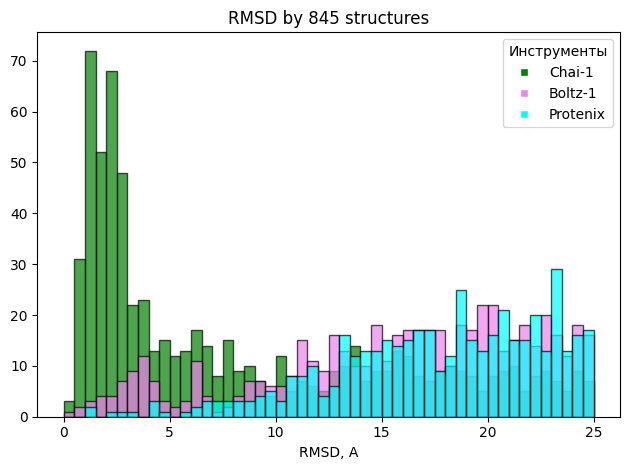

In [12]:
common_pdb_ids = set(rmsds_chai.keys()).intersection(rmsds_boltz.keys()).intersection(rmsds_protenix.keys())

plt.hist(
    [value for (key, value) in rmsds_chai.items() if key in common_pdb_ids],
    bins=50, range=(0, 25), alpha=0.7, color="green", edgecolor="black"
)
plt.hist(
    [value for (key, value) in rmsds_boltz.items() if key in common_pdb_ids],
    bins=50, range=(0, 25), alpha=0.7, color="violet", edgecolor="black"
)
plt.hist(
    [value for (key, value) in rmsds_protenix.items() if key in common_pdb_ids],
    bins=50, range=(0, 25), alpha=0.7, color="cyan", edgecolor="black"
)

plt.xlabel("RMSD, A")

# Создание собственных элементов легенды
custom_legend_elements = [
    plt.Line2D([0], [0], marker='s', color='w', label='Chai-1', markerfacecolor='green'),
    plt.Line2D([0], [0], marker='s', color='w', label='Boltz-1', markerfacecolor='violet'),
    plt.Line2D([0], [0], marker='s', color='w', label='Protenix', markerfacecolor='cyan')
]

# Отображаем легенду с нашими элементами
plt.legend(handles=custom_legend_elements, loc='upper right', title="Инструменты")

plt.title(f"RMSD by {len(common_pdb_ids)} structures")

plt.tight_layout()

plt.savefig("/mnt/storage/vladislove2020/NP_benchmark/plots/three.png", dpi=300)

In [117]:
cnt, cnt_started = 0, 0
for pdb_id in os.listdir("/mnt/storage/vladislove2020/NP_benchmark/chai-1/bench_3/results"):
    cnt += 1
    if len(os.listdir(f"/mnt/storage/vladislove2020/NP_benchmark/chai-1/bench_3/results/{pdb_id}")) > 0:
        cnt_started += 1
print(cnt, cnt_started)

1032 909


In [118]:
cnt, cnt_started = 0, 0
for pdb_id in os.listdir("/mnt/storage/vladislove2020/NP_benchmark/boltz-1/bench_3/results"):
    cnt += 1
    if len(os.listdir(f"/mnt/storage/vladislove2020/NP_benchmark/boltz-1/bench_3/results/{pdb_id}")) > 0:
        cnt_started += 1
print(cnt, cnt_started)

1032 1011


In [246]:
cnt, cnt_started = 0, 0
for pdb_id in os.listdir("/mnt/storage/vladislove2020/NP_benchmark/protenix/bench_3/results"):
    cnt += 1
    if len(os.listdir(f"/mnt/storage/vladislove2020/NP_benchmark/protenix/bench_3/results/{pdb_id}")) > 0:
        cnt_started += 1
print(cnt, cnt_started)

1032 1020


In [116]:
!cp -r /mnt/storage/vladislove2020/NP_benchmark/chai-1/bench_2/results/* /mnt/storage/vladislove2020/NP_benchmark/chai-1/bench_3/results

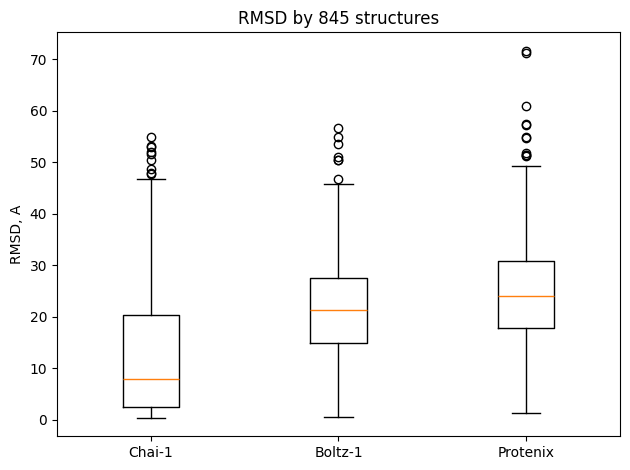

In [17]:
plt.boxplot(
    [
        [value for (key, value) in rmsds_chai.items() if key in common_pdb_ids],
        [value for (key, value) in rmsds_boltz.items() if key in common_pdb_ids],
        [value for (key, value) in rmsds_protenix.items() if key in common_pdb_ids]
    ],
    tick_labels=["Chai-1", "Boltz-1", "Protenix"],
    
)
plt.ylabel("RMSD, A")

plt.title(f"RMSD by {len(common_pdb_ids)} structures")

plt.tight_layout()
plt.savefig("/mnt/storage/vladislove2020/NP_benchmark/plots/three_boxplot.png", dpi=300)

In [18]:
rmsds_chai_na_only = {}

for pdb_id in tqdm(os.listdir("/mnt/storage/vladislove2020/NP_benchmark/chai-1/bench_3/results/")):
    try:
        rmsds_chai_na_only[pdb_id] = evaluate_prediction_na_only(
            original=prody.parsePDB(f"/mnt/storage/vladislove2020/masif_na/PN/{pdb_id}.ent.pdb"),
            prediction=prody.parsePDB(f"/mnt/storage/vladislove2020/NP_benchmark/chai-1/bench_3/results/{pdb_id}/pred.model_idx_0.cif")
        )
    except:
        continue

100%|██████████| 1032/1032 [02:22<00:00,  7.24it/s]


In [19]:
rmsds_boltz_na_only = {}

for pdb_id in tqdm(os.listdir("/mnt/storage/vladislove2020/NP_benchmark/boltz-1/bench_3/results/")):
    try:
        rmsds_boltz_na_only[pdb_id] = evaluate_prediction_na_only(
            original=prody.parsePDB(f"/mnt/storage/vladislove2020/masif_na/PN/{pdb_id}.ent.pdb"),
            prediction=prody.parsePDB(
f"/mnt/storage/vladislove2020/NP_benchmark/boltz-1/bench_3/results/{pdb_id}/boltz_results_{pdb_id}/predictions/{pdb_id}/{pdb_id}_model_0.pdb"
            )
        )
    except:
        continue

100%|██████████| 1032/1032 [02:14<00:00,  7.67it/s]


In [20]:
rmsds_protenix_na_only = {}

for pdb_id in tqdm(os.listdir("/mnt/storage/vladislove2020/NP_benchmark/protenix/bench_3/results")):
    try:
        rmsds_protenix_na_only[pdb_id] = evaluate_prediction_na_only(
            original=prody.parsePDB(f"/mnt/storage/vladislove2020/masif_na/PN/{pdb_id}.ent.pdb"),
            prediction=prody.parsePDB(
f"/mnt/storage/vladislove2020/NP_benchmark/protenix/bench_3/results/{pdb_id}/{pdb_id}/seed_101/predictions/{pdb_id}_seed_101_sample_0.cif"
            )
        )
    except:
        continue

100%|██████████| 1032/1032 [02:27<00:00,  6.98it/s]


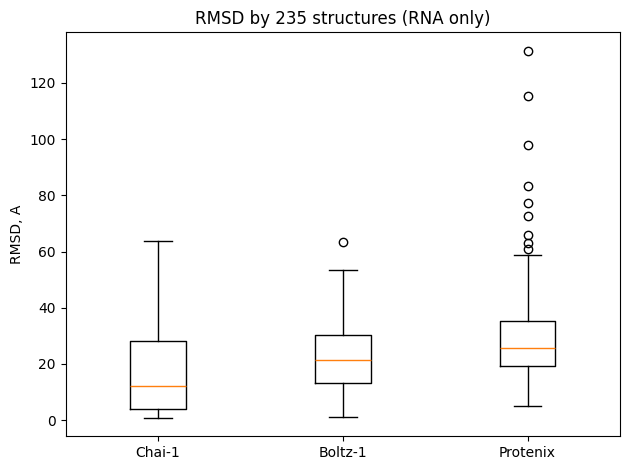

In [21]:
rmsds_chai_rna = {key: value for (key, value) in rmsds_chai_na_only.items() if pdb_id_to_na_type[key] == "rna"}
rmsds_boltz_rna = {key: value for (key, value) in rmsds_boltz_na_only.items() if pdb_id_to_na_type[key] == "rna"}
rmsds_protenix_rna = {key: value for (key, value) in rmsds_protenix_na_only.items() if pdb_id_to_na_type[key] == "rna"}

rmsds_chai_dna = {key: value for (key, value) in rmsds_chai_na_only.items() if pdb_id_to_na_type[key] == "dna"}
rmsds_boltz_dna = {key: value for (key, value) in rmsds_boltz_na_only.items() if pdb_id_to_na_type[key] == "dna"}
rmsds_protenix_dna = {key: value for (key, value) in rmsds_protenix_na_only.items() if pdb_id_to_na_type[key] == "dna"}

common_pdb_ids_rna = set(rmsds_chai_rna.keys()).intersection(rmsds_boltz_rna.keys()).intersection(rmsds_protenix_rna.keys())
common_pdb_ids_dna = set(rmsds_chai_dna.keys()).intersection(rmsds_boltz_dna.keys()).intersection(rmsds_protenix_dna.keys())

plt.boxplot(
    [
        [value for (key, value) in rmsds_chai_rna.items() if key in common_pdb_ids_rna],
        [value for (key, value) in rmsds_boltz_rna.items() if key in common_pdb_ids_rna],
        [value for (key, value) in rmsds_protenix_rna.items() if key in common_pdb_ids_rna]
    ],
    tick_labels=["Chai-1", "Boltz-1", "Protenix"],
    
)
plt.ylabel("RMSD, A")

plt.title(f"RMSD by {len(common_pdb_ids_rna)} structures (RNA only)")

plt.tight_layout()
plt.savefig("/mnt/storage/vladislove2020/NP_benchmark/plots/three_boxplot_rna.png", dpi=300)

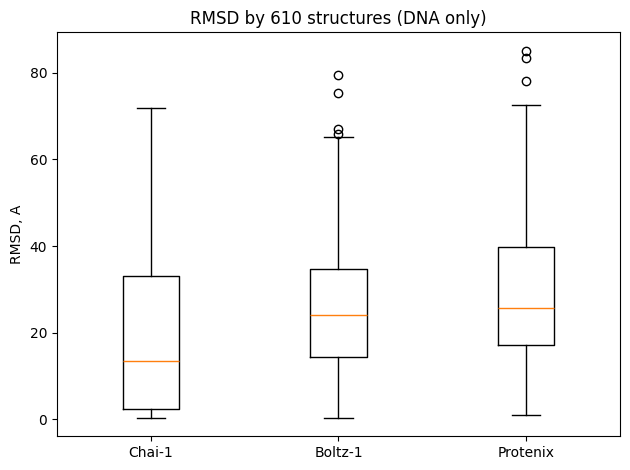

In [22]:
plt.boxplot(
    [
        [value for (key, value) in rmsds_chai_dna.items() if key in common_pdb_ids_dna],
        [value for (key, value) in rmsds_boltz_dna.items() if key in common_pdb_ids_dna],
        [value for (key, value) in rmsds_protenix_dna.items() if key in common_pdb_ids_dna]
    ],
    tick_labels=["Chai-1", "Boltz-1", "Protenix"],
    
)
plt.ylabel("RMSD, A")

plt.title(f"RMSD by {len(common_pdb_ids_dna)} structures (DNA only)")

plt.tight_layout()
plt.savefig("/mnt/storage/vladislove2020/NP_benchmark/plots/three_boxplot_dna.png", dpi=300)